In [58]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns


In [59]:
df = pd.read_csv(r"../cleaned_data/cleaned_data.csv")

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8476 entries, 0 to 8475
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    8476 non-null   float64
 1   RoomService            8476 non-null   float64
 2   FoodCourt              8476 non-null   float64
 3   ShoppingMall           8476 non-null   float64
 4   Spa                    8476 non-null   float64
 5   VRDeck                 8476 non-null   float64
 6   HomePlanet             8476 non-null   object 
 7   Destination            8476 non-null   object 
 8   VIP                    8476 non-null   bool   
 9   CryoSleep              8476 non-null   bool   
 10  Transported            8476 non-null   bool   
 11  cabin_group            8476 non-null   object 
 12  RoomService_customer   8476 non-null   bool   
 13  FoodCourt_customer     8476 non-null   bool   
 14  ShappingMall_customer  8476 non-null   bool   
 15  Spa_

In [61]:
df.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,Destination,VIP,CryoSleep,Transported,cabin_group,RoomService_customer,FoodCourt_customer,ShappingMall_customer,Spa_customer,VRDeck_customer
0,39.0,0.0,0.0,0.0,0.0,0.0,Europa,TRAPPIST-1e,False,False,False,B,False,False,False,False,False
1,24.0,109.0,9.0,25.0,549.0,44.0,Earth,TRAPPIST-1e,False,False,True,F,True,True,True,True,True
2,58.0,43.0,3576.0,0.0,6715.0,49.0,Europa,TRAPPIST-1e,True,False,False,A,True,True,False,True,True
3,33.0,0.0,1283.0,371.0,3329.0,193.0,Europa,TRAPPIST-1e,False,False,False,A,False,True,True,True,True
4,16.0,303.0,70.0,151.0,565.0,2.0,Earth,TRAPPIST-1e,False,False,True,F,True,True,True,True,True


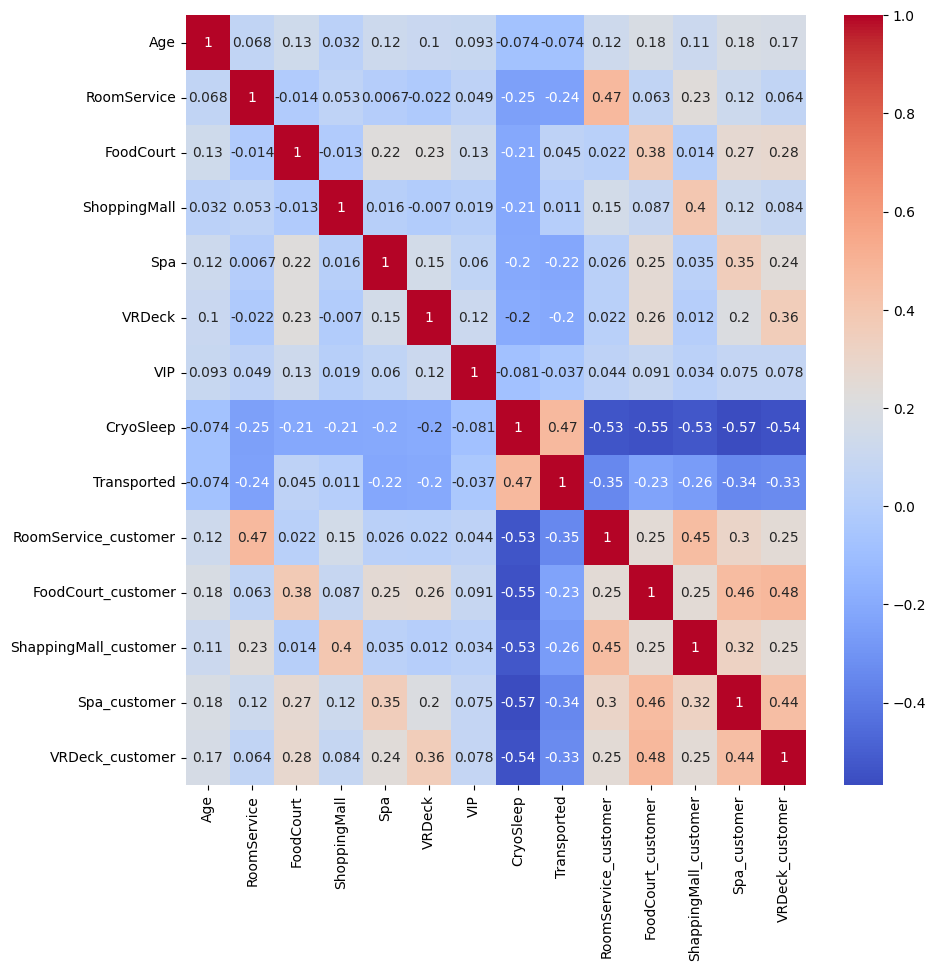

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
corr = df.corr(numeric_only=True)

sns.heatmap(
corr,
annot=True,
cmap='coolwarm'
)
plt.show()

<Axes: >

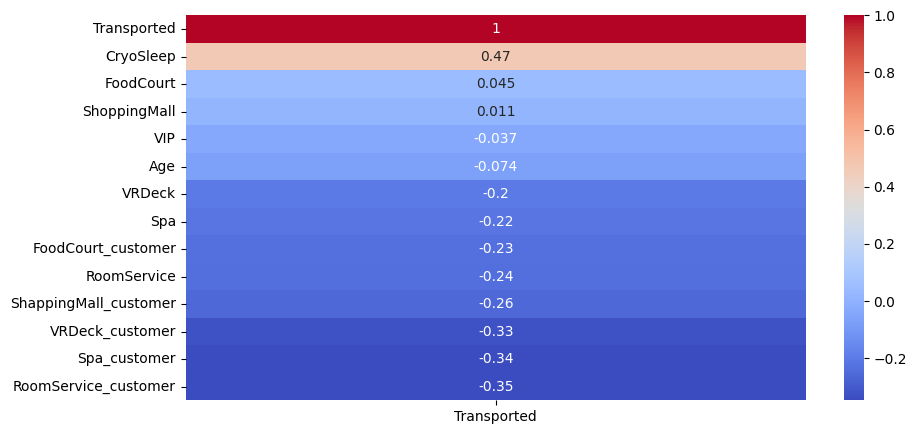

In [63]:
fig, ax = plt.subplots(figsize=(10,5))
corr = df.corr(numeric_only=True)

sns.heatmap(
    corr[['Transported']].sort_values(by='Transported', ascending=False),
    annot=True,
    cmap='coolwarm'
)

We see some good correlations in the data; both positive and negative. 

We also notice that the feature engineering implemented for columns such as FoodCourt_customer (-0.23) is doing well compared to original columns such as FoodCourt (0.045)

I will split the data into training and test sets, then I will conduct feature scaling before checking the correlations again. 

In [64]:
x = df.drop('Transported', axis=1)
y = df[['Transported']]

In [65]:
x.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,Destination,VIP,CryoSleep,cabin_group,RoomService_customer,FoodCourt_customer,ShappingMall_customer,Spa_customer,VRDeck_customer
0,39.0,0.0,0.0,0.0,0.0,0.0,Europa,TRAPPIST-1e,False,False,B,False,False,False,False,False
1,24.0,109.0,9.0,25.0,549.0,44.0,Earth,TRAPPIST-1e,False,False,F,True,True,True,True,True
2,58.0,43.0,3576.0,0.0,6715.0,49.0,Europa,TRAPPIST-1e,True,False,A,True,True,False,True,True
3,33.0,0.0,1283.0,371.0,3329.0,193.0,Europa,TRAPPIST-1e,False,False,A,False,True,True,True,True
4,16.0,303.0,70.0,151.0,565.0,2.0,Earth,TRAPPIST-1e,False,False,F,True,True,True,True,True


In [66]:
y.head()

,Transported
0,False
1,True
2,False
3,False
4,True


In [67]:
X_train,X_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=12, stratify=y)

In [68]:
X_train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,Destination,VIP,CryoSleep,cabin_group,RoomService_customer,FoodCourt_customer,ShappingMall_customer,Spa_customer,VRDeck_customer
7432,18.0,0.0,17.0,5.0,0.0,712.0,Earth,TRAPPIST-1e,False,False,F,False,True,True,False,True
6695,27.0,0.0,1.0,12.0,0.0,779.0,Earth,TRAPPIST-1e,False,False,E,False,True,True,False,True
3594,29.0,3478.0,11153.0,15.0,203.0,15.0,Europa,TRAPPIST-1e,False,False,C,True,True,True,True,True
763,4.0,0.0,0.0,0.0,0.0,0.0,Earth,55 Cancri e,False,True,G,False,False,False,False,False
1997,24.0,0.0,421.0,0.0,207.0,63.0,Earth,55 Cancri e,False,False,F,False,True,False,True,True


In [69]:
X_train.shape

(6780, 16)

In [70]:
y_train.shape

(6780, 1)

In [71]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6780 entries, 7432 to 3120
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    6780 non-null   float64
 1   RoomService            6780 non-null   float64
 2   FoodCourt              6780 non-null   float64
 3   ShoppingMall           6780 non-null   float64
 4   Spa                    6780 non-null   float64
 5   VRDeck                 6780 non-null   float64
 6   HomePlanet             6780 non-null   object 
 7   Destination            6780 non-null   object 
 8   VIP                    6780 non-null   bool   
 9   CryoSleep              6780 non-null   bool   
 10  cabin_group            6780 non-null   object 
 11  RoomService_customer   6780 non-null   bool   
 12  FoodCourt_customer     6780 non-null   bool   
 13  ShappingMall_customer  6780 non-null   bool   
 14  Spa_customer           6780 non-null   bool   
 15  VRDeck

In [72]:
set(y_train)

{'Transported'}

In [73]:
num_cols = []
one_hot = []

for col in X_train.columns:
    if X_train[col].dtype == 'float64':
        num_cols.append(col)
    else:
        one_hot.append(col)

print('*' * 62)
print("num_cols")
print(num_cols)
print("")
print('*' * 62)
print("one_hot")
print(one_hot)

**************************************************************
num_cols
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

**************************************************************
one_hot
['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'cabin_group', 'RoomService_customer', 'FoodCourt_customer', 'ShappingMall_customer', 'Spa_customer', 'VRDeck_customer']


In [74]:
num_pipeline = Pipeline(
    steps=[('scaler', StandardScaler())]
)

one_hot_pipeline = Pipeline(
    steps=[('one_hot', OneHotEncoder(handle_unknown='ignore'))]
)

In [75]:
processor_model = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('one_hot', one_hot_pipeline, one_hot)
])

In [76]:
X_processed = processor_model.fit_transform(X_train)

X_features = processor_model.get_feature_names_out()

In [77]:
len(X_processed)

6780

In [78]:
X_features

array(['num__Age', 'num__RoomService', 'num__FoodCourt',
       'num__ShoppingMall', 'num__Spa', 'num__VRDeck',
       'one_hot__HomePlanet_Earth', 'one_hot__HomePlanet_Europa',
       'one_hot__HomePlanet_Mars', 'one_hot__HomePlanet_unknown',
       'one_hot__Destination_55 Cancri e',
       'one_hot__Destination_PSO J318.5-22',
       'one_hot__Destination_TRAPPIST-1e', 'one_hot__Destination_unknown',
       'one_hot__VIP_False', 'one_hot__VIP_True',
       'one_hot__CryoSleep_False', 'one_hot__CryoSleep_True',
       'one_hot__cabin_group_A', 'one_hot__cabin_group_B',
       'one_hot__cabin_group_C', 'one_hot__cabin_group_D',
       'one_hot__cabin_group_E', 'one_hot__cabin_group_F',
       'one_hot__cabin_group_G', 'one_hot__cabin_group_T',
       'one_hot__RoomService_customer_False',
       'one_hot__RoomService_customer_True',
       'one_hot__FoodCourt_customer_False',
       'one_hot__FoodCourt_customer_True',
       'one_hot__ShappingMall_customer_False',
       'one_hot__Sha

In [79]:
X_train_processed_df = pd.DataFrame(X_processed, columns=X_features, index=X_train.index)

In [80]:
X_train_processed_df

,num__Age,num__RoomService,num__FoodCourt,num__ShoppingMall,num__Spa,num__VRDeck,one_hot__HomePlanet_Earth,one_hot__HomePlanet_Europa,one_hot__HomePlanet_Mars,one_hot__HomePlanet_unknown,...,one_hot__RoomService_customer_False,one_hot__RoomService_customer_True,one_hot__FoodCourt_customer_False,one_hot__FoodCourt_customer_True,one_hot__ShappingMall_customer_False,one_hot__ShappingMall_customer_True,one_hot__Spa_customer_False,one_hot__Spa_customer_True,one_hot__VRDeck_customer_False,one_hot__VRDeck_customer_True
7432,-0.754472,-0.332213,-0.275362,-0.290058,-0.265089,0.380941,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
6695,-0.130754,-0.332213,-0.285884,-0.277672,-0.265089,0.441782,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3594,0.007850,4.763823,7.048346,-0.272363,-0.092470,-0.251989,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
763,-1.724699,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1997,-0.338660,-0.332213,-0.009667,-0.298906,-0.089069,-0.208402,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157,-0.130754,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2767,0.562266,1.259016,-0.286542,-0.298906,-0.230225,-0.265611,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1443,-0.477264,1.159381,-0.220776,-0.298906,-0.257436,-0.265611,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3578,0.354360,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [81]:
y_train

,Transported
7432,True
6695,False
3594,True
763,True
1997,False
...,...
5157,True
2767,False
1443,False
3578,True


In [82]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6780 entries, 7432 to 3120
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Transported  6780 non-null   bool 
dtypes: bool(1)
memory usage: 59.6 KB


In [83]:
X_processed_df_full = pd.concat([X_train_processed_df, y_train], axis=1)

In [84]:
X_processed_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6780 entries, 7432 to 3120
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   num__Age                              6780 non-null   float64
 1   num__RoomService                      6780 non-null   float64
 2   num__FoodCourt                        6780 non-null   float64
 3   num__ShoppingMall                     6780 non-null   float64
 4   num__Spa                              6780 non-null   float64
 5   num__VRDeck                           6780 non-null   float64
 6   one_hot__HomePlanet_Earth             6780 non-null   float64
 7   one_hot__HomePlanet_Europa            6780 non-null   float64
 8   one_hot__HomePlanet_Mars              6780 non-null   float64
 9   one_hot__HomePlanet_unknown           6780 non-null   float64
 10  one_hot__Destination_55 Cancri e      6780 non-null   float64
 11  one_hot__Destinatio

In [85]:
X_processed_df_full

,num__Age,num__RoomService,num__FoodCourt,num__ShoppingMall,num__Spa,num__VRDeck,one_hot__HomePlanet_Earth,one_hot__HomePlanet_Europa,one_hot__HomePlanet_Mars,one_hot__HomePlanet_unknown,...,one_hot__RoomService_customer_True,one_hot__FoodCourt_customer_False,one_hot__FoodCourt_customer_True,one_hot__ShappingMall_customer_False,one_hot__ShappingMall_customer_True,one_hot__Spa_customer_False,one_hot__Spa_customer_True,one_hot__VRDeck_customer_False,one_hot__VRDeck_customer_True,Transported
7432,-0.754472,-0.332213,-0.275362,-0.290058,-0.265089,0.380941,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,True
6695,-0.130754,-0.332213,-0.285884,-0.277672,-0.265089,0.441782,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,False
3594,0.007850,4.763823,7.048346,-0.272363,-0.092470,-0.251989,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,True
763,-1.724699,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,True
1997,-0.338660,-0.332213,-0.009667,-0.298906,-0.089069,-0.208402,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157,-0.130754,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,True
2767,0.562266,1.259016,-0.286542,-0.298906,-0.230225,-0.265611,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,False
1443,-0.477264,1.159381,-0.220776,-0.298906,-0.257436,-0.265611,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,False
3578,0.354360,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,True


<Axes: >

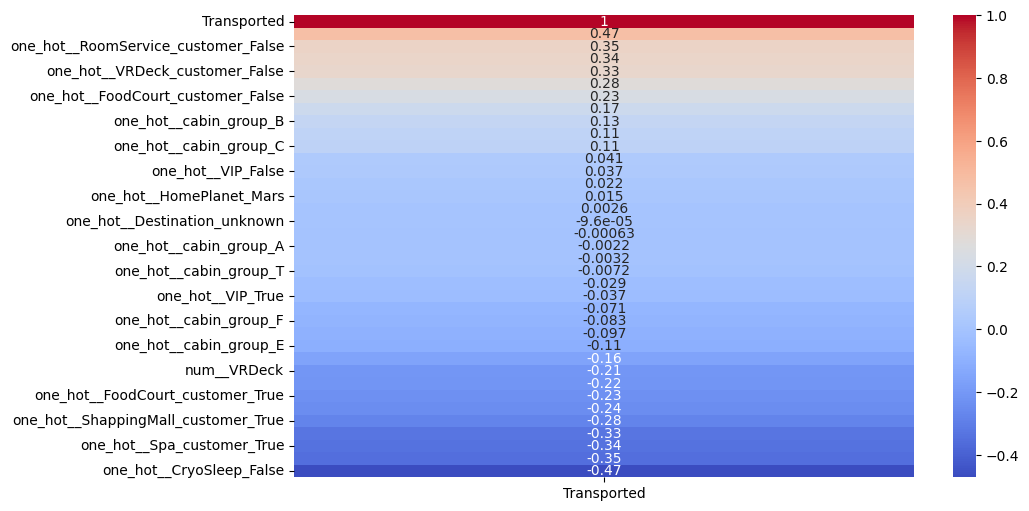

In [91]:
corr2 = X_processed_df_full.corr()

fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(corr2[['Transported']].sort_values(by='Transported', ascending=False), annot=True, cmap='coolwarm'

)


